In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data="/content/drive/MyDrive/NeuroTone/TESS Toronto emotional speech set data"

In [ ]:
# file_emotion = []
# file_path = []

# tess_directory_list = os.listdir(data)

# for dir in tess_directory_list:
#     dir_path = os.path.join(data, dir)
#     if not os.path.isdir(dir_path):
#         continue

#     directories = os.listdir(dir_path)

#     for file in directories:
#         file_parts = file.split('.')[0].split('_')

#         if len(file_parts) < 3:
#             continue

#         emotion_code = file_parts[2]

#         emotion_dict = {
#             'ps': 'surprise',
#             'angry': 'anger',
#             'happy': 'happiness',
#             'sad': 'sadness',
#             'fear': 'fear',
#             'disgust': 'disgust',
#             'neutral': 'neutral',
#             'Sad':'sadness'
#         }

#         file_emotion.append(emotion_dict.get(emotion_code, 'unknown'))
#         file_path.append(os.path.join(dir_path, file))

# print(set(file_emotion))

In [ ]:
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Tess_df = pd.concat([emotion_df, path_df], axis=1)
# Tess_df.head()
# Tess_df.to_csv("/content/drive/MyDrive/NeuroTone/data_set.csv", index=False)

In [ ]:
final_data=pd.read_csv("/content/drive/MyDrive/NeuroTone/data_set.csv")
final_data.head()

,Emotions,Path
0,sadness,/content/drive/MyDrive/NeuroTone/TESS Toronto ...
1,sadness,/content/drive/MyDrive/NeuroTone/TESS Toronto ...
2,sadness,/content/drive/MyDrive/NeuroTone/TESS Toronto ...
3,sadness,/content/drive/MyDrive/NeuroTone/TESS Toronto ...
4,sadness,/content/drive/MyDrive/NeuroTone/TESS Toronto ...


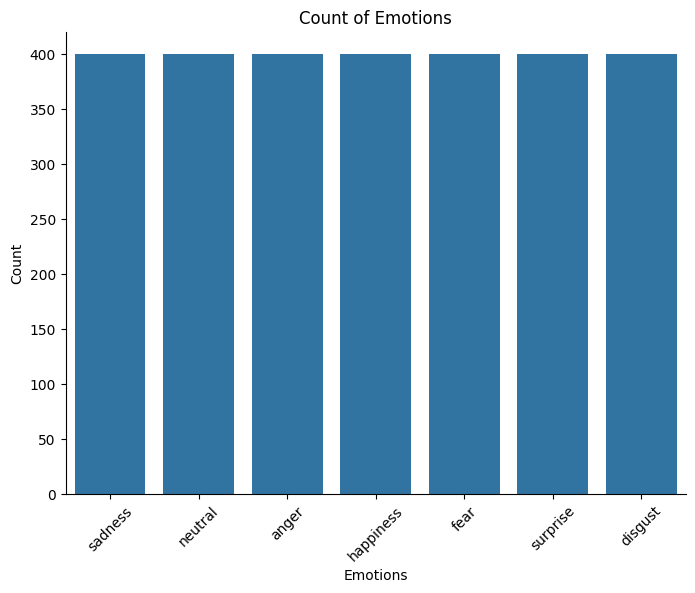

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Count of Emotions')
sns.countplot(x=final_data["Emotions"])
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=45)
plt.show()

In [ ]:
final_data['Emotions'].unique()

array(['sadness', 'neutral', 'anger', 'happiness', 'fear', 'surprise',
       'disgust'], dtype=object)

In [ ]:
audio_paths = final_data['Path'].values
emotions = final_data['Emotions'].values

In [ ]:
encoder = LabelEncoder()
emotions_encoded = encoder.fit_transform(emotions)
emotions_categorical = to_categorical(emotions_encoded)

In [ ]:
def augment_audio(y, sr):
    y = y + 0.005 * np.random.randn(len(y))
    return np.roll(y, shift=int(sr * 0.1))

In [ ]:
def extract_features(file_path, max_length=100):
    y,sr =librosa.load(file_path,sr=22050)
    y=augment_audio(y, sr)
    mfccs=librosa.feature.mfcc(y=y,sr=sr, n_mfcc=64)
    pad_width=max_length-mfccs.shape[1]
    if pad_width>0:
        mfccs=np.pad(mfccs,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfccs = mfccs[:, :max_length]
    return mfccs[..., np.newaxis]

In [ ]:
features = np.array([extract_features(file) for file in audio_paths])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, emotions_categorical, test_size=0.2, random_state=42)

In [ ]:
 X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
num_classes = len(final_data['Emotions'].unique())
model = Sequential([
    Input(shape=(64, 100, 1)),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Conv2D(128, kernel_size=(3,3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - accuracy: 0.5209 - loss: 4.1628 - val_accuracy: 0.9071 - val_loss: 0.5426
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9455 - loss: 0.4157 - val_accuracy: 0.9036 - val_loss: 0.4919
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9579 - loss: 0.3702 - val_accuracy: 0.9875 - val_loss: 0.2896
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9831 - loss: 0.2997 - val_accuracy: 0.9875 - val_loss: 0.2874
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9895 - loss: 0.2821 - val_accuracy: 0.9964 - val_loss: 0.2584
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9908 - loss: 0.2759 - val_accuracy: 0.9982 - val_loss: 0.2440
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9949 - loss: 0.2567 - val_accuracy: 0.9982 - val_loss: 0.2400
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9909 - loss: 0.2571 - val_accuracy: 0.9946 -

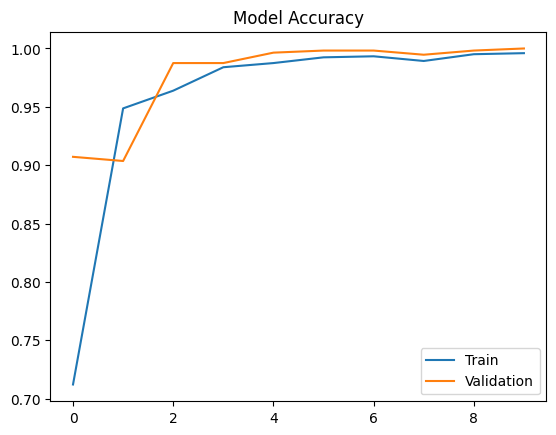

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/NeuroTone/sound_to_emotion_model.keras')